# Jores et al 2021 Evaluation 
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to perform a brief evaluation of trained models on the Jores et al dataset.
***

In [35]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [23]:
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/jores21"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/jores21"
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/jores21"
figure_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/figures/jores21"
eu.settings.verbosity = logging.ERROR
eu.settings.batch_size = 128
eu.settings.dl_num_workers = 0

# Load in the `leaf`, `proto` and `combined` test `SeqData`s 

In [3]:
# Load in the preprocessed training data
sdata_leaf = eu.dl.read(os.path.join(eu.settings.dataset_dir, "leaf_processed_test.h5sd"))
sdata_proto = eu.dl.read(os.path.join(eu.settings.dataset_dir, "proto_processed_test.h5sd"))
sdata_combined = eu.dl.concat([sdata_leaf, sdata_proto], keys=["leaf", "proto"])
sdata_leaf, sdata_proto, sdata_combined

(SeqData object with = 7154 seqs
 seqs = (7154,)
 names = (7154,)
 rev_seqs = (7154,)
 ohe_seqs = (7154, 170, 4)
 ohe_rev_seqs = (7154, 170, 4)
 seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'type'
 pos_annot: None
 seqsm: None
 uns: None,
 SeqData object with = 7595 seqs
 seqs = (7595,)
 names = (7595,)
 rev_seqs = (7595,)
 ohe_seqs = (7595, 170, 4)
 ohe_rev_seqs = (7595, 170, 4)
 seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'type'
 pos_annot: None
 seqsm: None
 uns: None,
 SeqData object with = 14749 seqs
 seqs = (14749,)
 names = (14749,)
 rev_seqs = (14749,)
 ohe_seqs = (14749, 170, 4)
 ohe_rev_seqs = (14749, 170, 4)
 seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'type'
 pos_annot: None
 seqsm: None
 uns: None)

# Get test set predictions for each model

In [4]:
# Train 5 models with 5 different random initializations
model_types = ["CNN", "Hybrid", "Jores21CNN"]
model_names = ["ssCNN", "ssHybrid", "Jores21CNN"]
trials = 5
for model_name, model_type in zip(model_names, model_types):
    for trial in range(1, trials+1):
        print(f"{model_name} trial {trial}")
        model_file = glob.glob(os.path.join(eu.settings.logging_dir, model_name, f"leaf_trial_{trial}", "checkpoints", "*"))[0]
        if model_type == "CNN":
            leaf_model = eu.models.CNN.load_from_checkpoint(model_file)
        elif model_type == "Hybrid":
            leaf_model = eu.models.Hybrid.load_from_checkpoint(model_file)
        elif model_type == "Jores21CNN":
            leaf_model = eu.models.Jores21CNN.load_from_checkpoint(model_file)
        eu.predict.predictions(
            leaf_model,
            sdata=sdata_leaf,
            target="enrichment",
            name=model_name,
            version=f"leaf_trial_{trial}",
            file_label="test",
            prefix=f"{model_name}_trial_{trial}_"
        )
        del leaf_model
sdata_leaf.write_h5sd(os.path.join(eu.settings.output_dir, "leaf_test_predictions.h5sd"))

ssCNN trial 1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `predict_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + ssCNN_trial_1_enrichment_predictions
ssCNN trial 2


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + ssCNN_trial_2_enrichment_predictions
ssCNN trial 3


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + ssCNN_trial_3_enrichment_predictions
ssCNN trial 4


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + ssCNN_trial_4_enrichment_predictions
ssCNN trial 5


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + ssCNN_trial_5_enrichment_predictions
ssHybrid trial 1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + ssHybrid_trial_1_enrichment_predictions
ssHybrid trial 2


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + ssHybrid_trial_2_enrichment_predictions
ssHybrid trial 3


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + ssHybrid_trial_3_enrichment_predictions
ssHybrid trial 4


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + ssHybrid_trial_4_enrichment_predictions
ssHybrid trial 5


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + ssHybrid_trial_5_enrichment_predictions
Jores21CNN trial 1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + Jores21CNN_trial_1_enrichment_predictions
Jores21CNN trial 2


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + Jores21CNN_trial_2_enrichment_predictions
Jores21CNN trial 3


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + Jores21CNN_trial_3_enrichment_predictions
Jores21CNN trial 4


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + Jores21CNN_trial_4_enrichment_predictions
Jores21CNN trial 5


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + Jores21CNN_trial_5_enrichment_predictions


In [ ]:
# Train 5 models with 5 different random initializations
model_types = ["CNN", "Jores21CNN"]
model_names = ["ssCNN", "Jores21CNN"]
trials = 5
for model_name, model_type in zip(model_names, model_types):
    for trial in range(1, trials+1):
        print(f"{model_name} trial {trial}")
        model_file = glob.glob(os.path.join(eu.settings.logging_dir, model_name, f"proto_trial_{trial}", "checkpoints", "*"))[0]
        if model_type == "CNN":
            proto_model = eu.models.CNN.load_from_checkpoint(model_file)

        elif model_type == "Jores21CNN":
            proto_model = eu.models.Jores21CNN.load_from_checkpoint(model_file)
        eu.predict.predictions(
            proto_model,
            sdata=sdata_proto,
            target="enrichment",
            name=model_name,
            version=f"proto_trial_{trial}",
            file_label="test",
            prefix=f"{model_name}_trial_{trial}_"
        )
        del proto_model
sdata_proto.write_h5sd(os.path.join(eu.settings.output_dir, "proto_predictions.h5sd"))

In [ ]:
# Train 5 models with 5 different random initializations
model_types = ["CNN", "Jores21CNN"]
model_names = ["ssCNN", "Jores21CNN"]
trials = 5
sdata_proto = sdata_proto[:100]
for model_name, model_type in zip(model_names, model_types):
    for trial in range(1, trials+1):
        print(f"{model_name} trial {trial}")
        model_file = glob.glob(os.path.join(eu.settings.logging_dir, model_name, f"proto_trial_{trial}", "checkpoints", "*"))[0]
        if model_type == "CNN":
            proto_model = eu.models.CNN.load_from_checkpoint(model_file)
        elif model_type == "Jores21CNN":
            proto_model = eu.models.Jores21CNN.load_from_checkpoint(model_file)
        eu.predict.predictions(
            proto_model,
            sdata=sdata_proto,
            target="enrichment",
            name=model_name,
            version=f"proto_trial_{trial}",
            file_label="test",
            prefix=f"{model_name}_trial_{trial}_"
        )
        del proto_model
sdata_proto.write_h5sd(os.path.join(eu.settings.output_dir, "proto_predictions.h5sd"))

In [ ]:
# Train 5 models with 5 different random initializations
model_types = ["CNN", "Jores21CNN"]
model_names = ["ssCNN", "Jores21CNN"]
trials = 5
sdata_combined = sdata_combined[:100]
for model_name, model_type in zip(model_names, model_types):
    for trial in range(1, trials+1):
        print(f"{model_name} trial {trial}")
        model_file = glob.glob(os.path.join(eu.settings.logging_dir, model_name, f"combined_trial_{trial}", "checkpoints", "*"))[0]
        if model_type == "CNN":
            combined_model = eu.models.CNN.load_from_checkpoint(model_file)
        elif model_type == "Jores21CNN":
            combined_model = eu.models.Jores21CNN.load_from_checkpoint(model_file)
        eu.predict.predictions(
            combined_model,
            sdata=sdata_combined,
            target="enrichment",
            name=model_name,
            version=f"combined_trial_{trial}",
            file_label="test",
            prefix=f"{model_name}_trial_{trial}_"
        )
        del combined_model
sdata_combined.write_h5sd(os.path.join(eu.settings.output_dir, "combined_predictions.h5sd"))

# Generate performance figures

## Leaf

Index(['r2', 'mse', 'pearson', 'spearman', 'kendall', 'prediction_groups'], dtype='object')


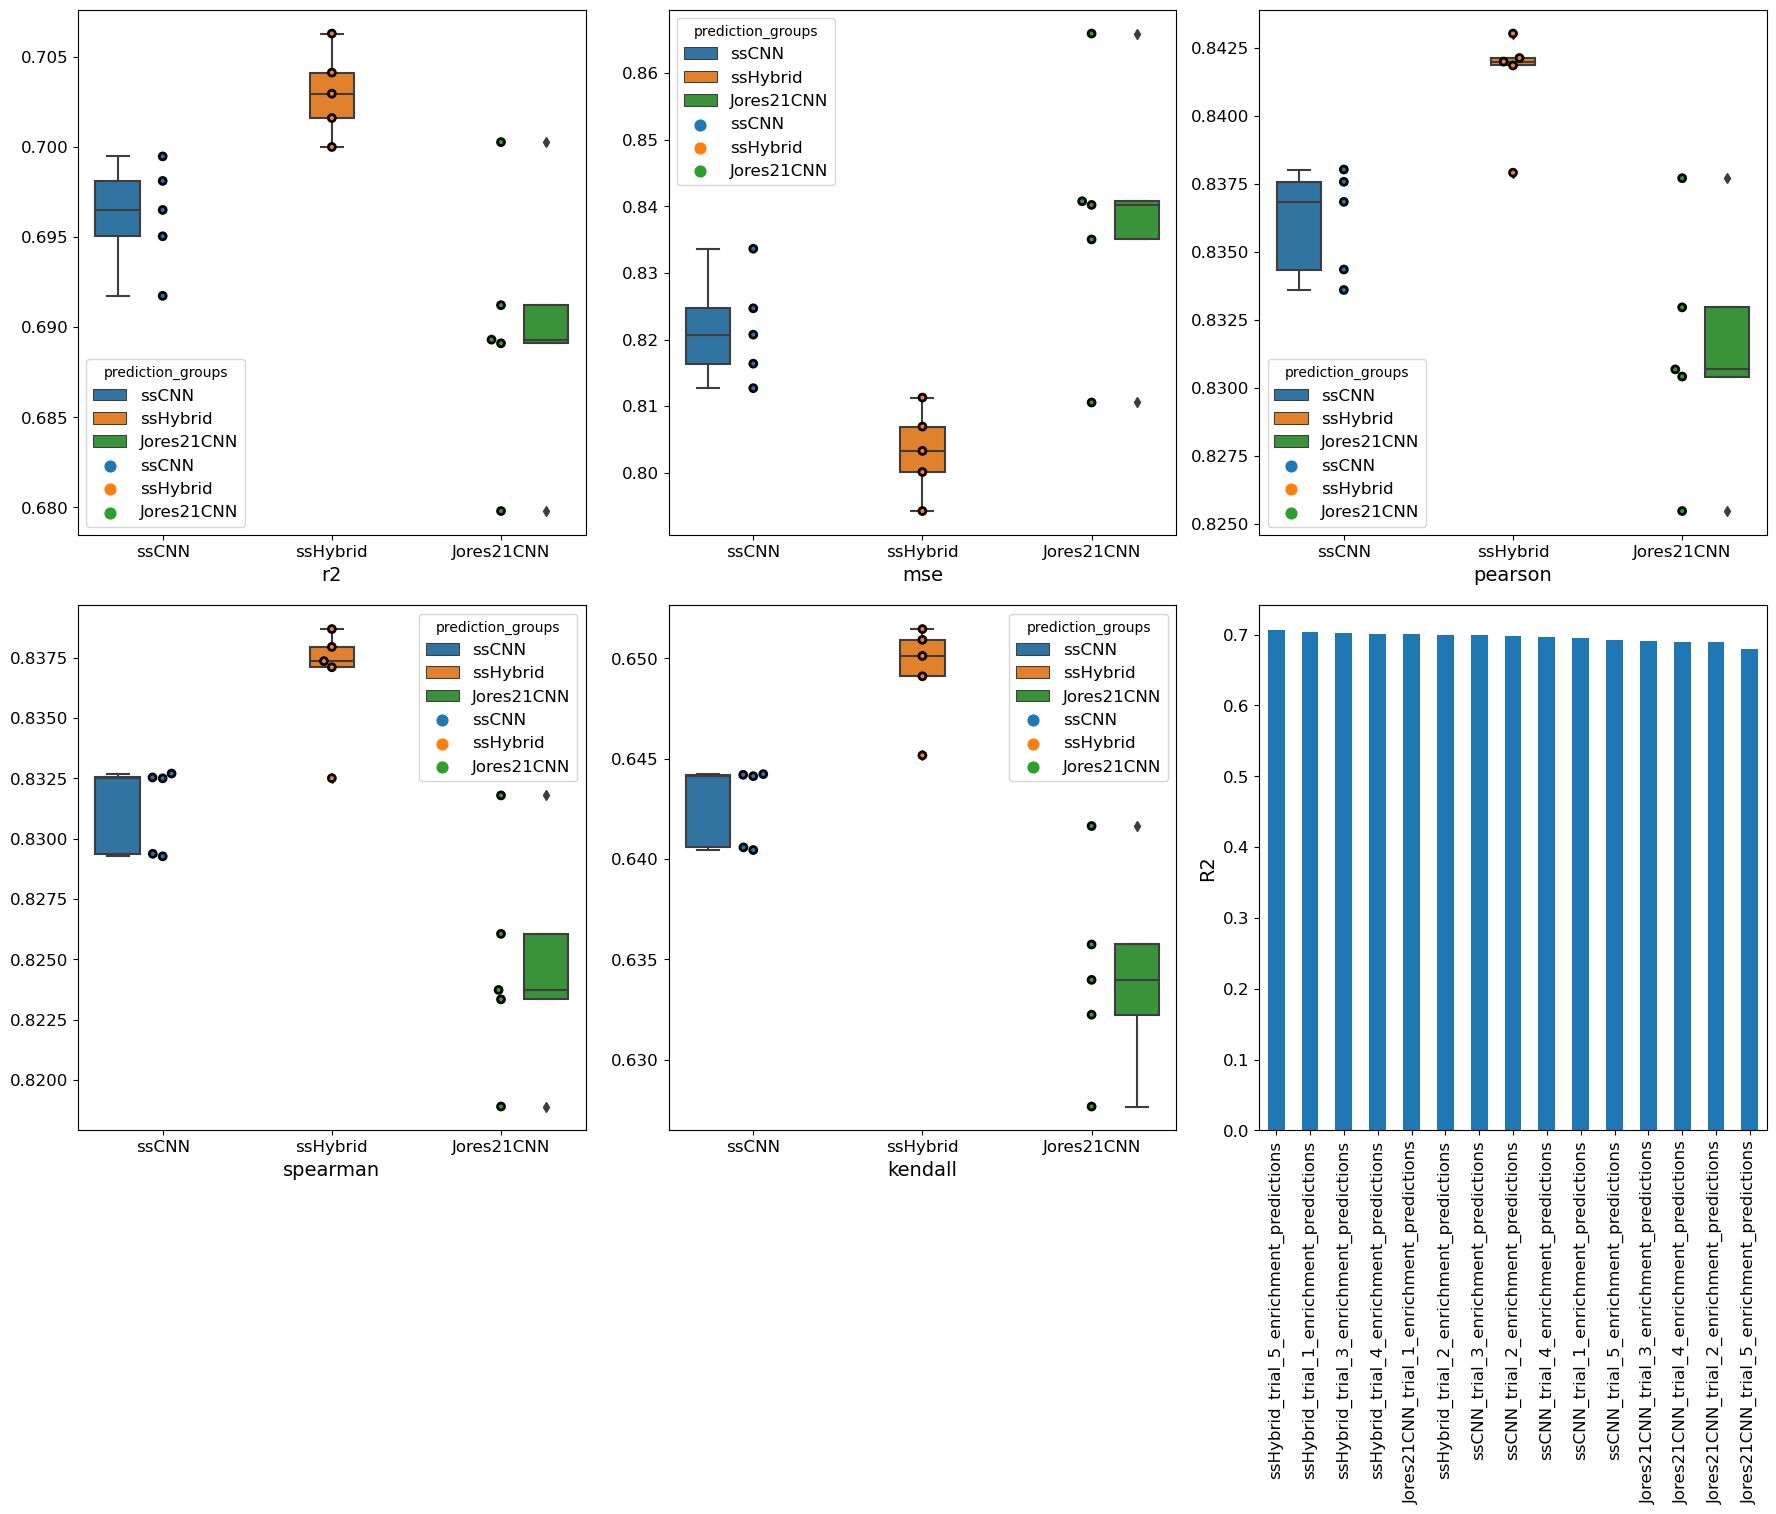

In [36]:
# Summarize performance across models for a metric
model_scores = eu.pl.performance_summary(
    sdata_leaf,
    target="enrichment",
    prediction_groups=["ssCNN"]*5 + ["ssHybrid"]*5 + ["Jores21CNN"]*5,
    hue="prediction_groups",
    metrics=["r2", "mse", "pearson", "spearman", "kendall"],
    add_swarm=True,
    figsize=(6, 6),
)

# Identify the best model from returned model scores
r2_sorted = model_scores["r2"].sort_values(ascending=False)
r2_sorted.plot(kind="bar", ylabel="R2")
plt.savefig(os.path.join(figure_dir, "leaf_performance_summary.pdf"))

Group R2 MSE Spearmanr
At 0.5301689966006582 0.6543972114941272 0.715378629929848
Sb 0.6698346926084631 0.8964047203911658 0.834687994523138
Zm 0.7409129052765797 0.7888804656809936 0.8644641148165886


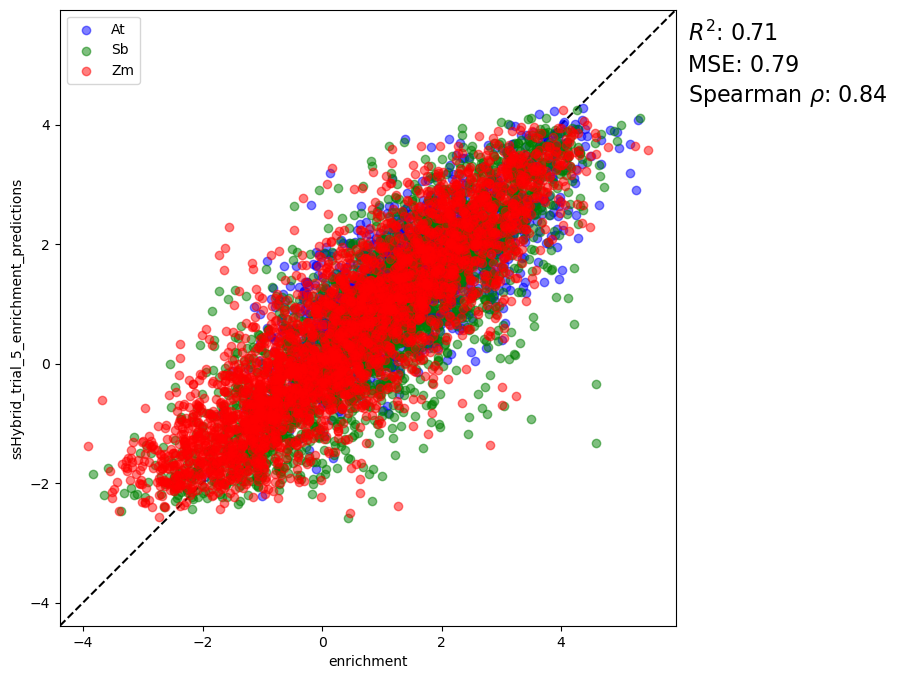

In [37]:
# Plot the performances across species for the best model
best_preds = r2_sorted.index[0]
ax = eu.pl.performance_scatter(
    sdata_leaf, 
    target="enrichment", 
    prediction=best_preds,
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8),
    rasterized=True,
    save=os.path.join(figure_dir, "leaf_best_model_performance_scatter_by_sp.pdf")
)

## Proto models

<AxesSubplot:>

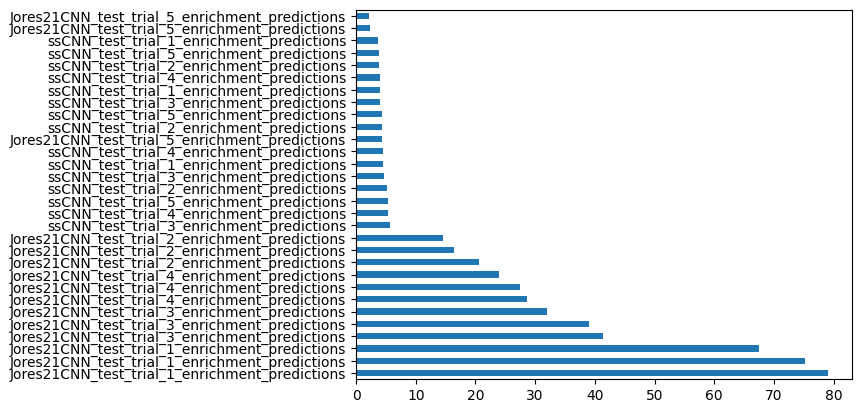

In [17]:
# Summarize performance across models for a metric
model_scores = eu.pl.performance_summary(
    sdata_proto,
    target="enrichment",
    prediction_groups=["ssCNN"]*5 + ["Jores21CNN"]*5,
    hue="prediction_groups",
    metrics=["r2", "mse", "pearson", "spearman", "kendall"],
    figsize=(4, 4),
    save=os.path.join(eu.settings.output_dir, "fig", "performance_summary.pdf")
)

# Identify the best model from returned model scores
model_scores["mse"].sort_values(ascending=False).plot(kind="barh")

# Plot the performances across species for the best model
ax = eu.pl.performance_scatter(
    sdata_proto, 
    target="enrichment", 
    prediction="Jores21CNN_trial_1_enrichment_predictions",
    alpha=0.5,
    c="GC",
    figsize=(10, 10),
    return_ax=True
)
ax.set_xlabel("Enrichment")

## Combined models

Text(0.5, 0, 'Enrichment')

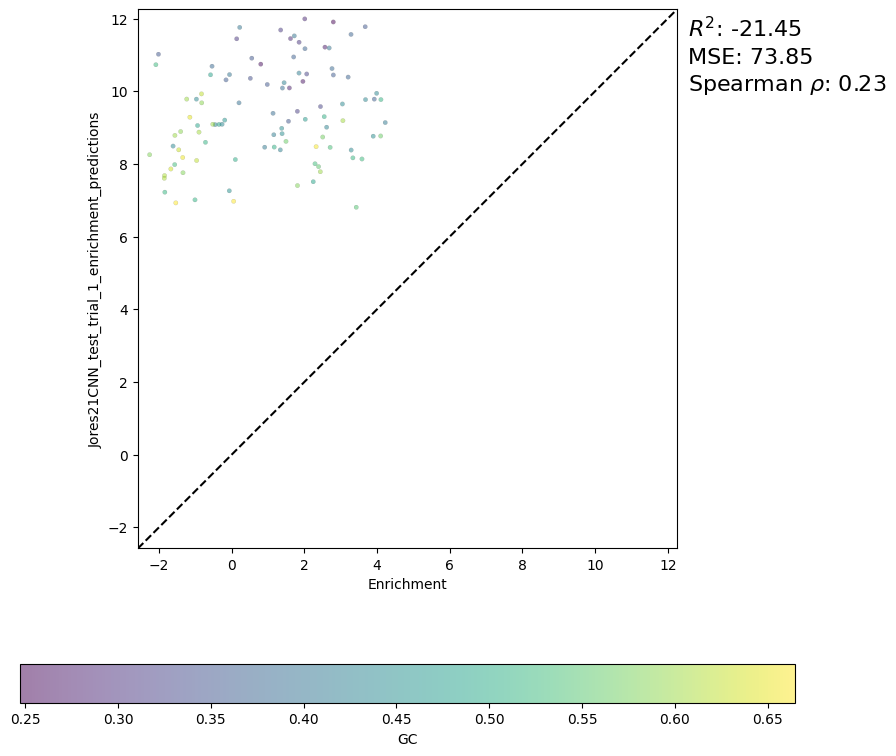

In [18]:
# Summarize performance across models for a metric
model_scores = eu.pl.performance_summary(
    sdata_combined,
    target="enrichment",
    prediction_groups=["ssCNN"]*5 + ["Jores21CNN"]*5,
    hue="prediction_groups",
    metrics=["r2", "mse", "pearson", "spearman", "kendall"],
    figsize=(4, 4),
    save=os.path.join(eu.settings.output_dir, "fig", "performance_summary.pdf")
)

# Identify the best model from returned model scores
model_scores["mse"].sort_values(ascending=False).plot(kind="barh")

# Plot the performances across species for the best model
ax = eu.pl.performance_scatter(
    sdata_combined, 
    target="enrichment", 
    prediction="Jores21CNN_trial_1_enrichment_predictions",
    alpha=0.5,
    c="GC",
    figsize=(10, 10),
    return_ax=True
)
ax.set_xlabel("Enrichment")

---

# Scratch

In [ ]:
metric_dict = {
    "r2": r2_score,
    "mse": mean_squared_error,
    "spearman": spearmanr,
    "pearson": pearsonr,
    "kendall": kendalltau,
}

def _model_performances_across_groups(
    sdataframe,
    target,
    prediction_labels=None,
    prediction_groups=None,
    groupby=None,
    metric="r2"
):
    func = metric_dict[metric]
    prediction_labels = sdataframe.columns[sdataframe.columns.str.contains("predictions")] if prediction_labels is None else prediction_labels
    conc = pd.DataFrame()
    for group, data in sdataframe.groupby(groupby):
        predicts = data[prediction_labels]
        true = data[target]
        if metric in ["r2", "mse"]:
            scores = predicts.apply(lambda x: func(true, x), axis=0).to_frame(name=metric)
        elif metric in ["spearman", "pearson", "kendall"]:
            scores = predicts.apply(lambda x: func(true, x)[0], axis=0).to_frame(name=metric)
        scores[groupby] = group
        if prediction_groups is not None:
            scores["prediction_groups"] = prediction_groups
        conc = pd.concat([conc, scores])
    return conc

def _model_performances(
    sdataframe,
    target,
    prediction_labels=None,
    prediction_groups=None,
    metric="r2"
):
    func = metric_dict[metric] 
    true = sdataframe[target]
    prediction_labels = sdataframe.columns[sdataframe.columns.str.contains("predictions")] if prediction_labels is None else prediction_labels
    predicts = sdataframe[prediction_labels]
    if metric in ["r2", "mse"]:
        scores = predicts.apply(lambda x: func(true, x), axis=0).to_frame(name=metric)
    elif metric in ["spearman", "pearson", "kendall"]:
        scores = predicts.apply(lambda x: func(true, x)[0], axis=0).to_frame(name=metric)
    if prediction_groups is not None:
        scores["prediction_groups"] = prediction_groups
    return scores

In [ ]:
_model_performances(
    sdata_leaf.seqs_annot,
    target="enrichment",
    prediction_groups=["ssCNN"]*5 + ["Jores21CNN"]*5,
    group=""
)

NameError: name '_model_performances' is not defined

In [ ]:
_model_performances_across_groups(
    sdata_leaf.seqs_annot,
    target="enrichment",
    prediction_groups=["ssCNN"]*5 + ["Jores21CNN"]*5,
    groupby="sp"
)

,r2,sp
ssCNN_test_trial_1_enrichment_predictions,-1.352166,At
ssCNN_test_trial_2_enrichment_predictions,-1.742816,At
ssCNN_test_trial_3_enrichment_predictions,-2.084355,At
ssCNN_test_trial_4_enrichment_predictions,-1.808771,At
ssCNN_test_trial_5_enrichment_predictions,-1.759070,At
Jores21CNN_test_trial_1_enrichment_predictions,-58.177661,At
Jores21CNN_test_trial_2_enrichment_predictions,-12.665144,At
Jores21CNN_test_trial_3_enrichment_predictions,-30.590108,At
Jores21CNN_test_trial_4_enrichment_predictions,-16.245465,At
Jores21CNN_test_trial_5_enrichment_predictions,-0.277247,At


In [ ]:
sns.boxplot(data=conc, x="sp", y="score")
sns.swarmplot(data=conc, x="sp", y="score", size=10, edgecolor="black", linewidth=2)

In [ ]:
metric = "pearson"
func = metric_dict[metric] 
groups = ["ssCNN"]*5 + ["Jores21CNN"]*5
key = "sp"
conc = pd.DataFrame()
for group, data in sdata_leaf.seqs_annot.groupby(key):
    predicts = data.columns[data.columns.str.contains("predictions")]
    true = data["enrichment"]
    if metric in ["r2", "mse"]:
        scores = data[predicts].apply(lambda x: func(true, x), axis=0).to_frame(name="score")
    elif metric in ["spearman", "pearson", "kendall"]:
        scores = data[predicts].apply(lambda x: func(true, x)[0], axis=0).to_frame(name="score")
    scores[key] = group
    scores["group"] = groups
    conc = pd.concat([conc, scores])
conc

,score,sp,group
ssCNN_test_trial_1_enrichment_predictions,0.063922,At,ssCNN
ssCNN_test_trial_2_enrichment_predictions,0.051965,At,ssCNN
ssCNN_test_trial_3_enrichment_predictions,0.052936,At,ssCNN
ssCNN_test_trial_4_enrichment_predictions,0.053968,At,ssCNN
ssCNN_test_trial_5_enrichment_predictions,0.015708,At,ssCNN
Jores21CNN_test_trial_1_enrichment_predictions,0.142556,At,Jores21CNN
Jores21CNN_test_trial_2_enrichment_predictions,0.122386,At,Jores21CNN
Jores21CNN_test_trial_3_enrichment_predictions,0.147584,At,Jores21CNN
Jores21CNN_test_trial_4_enrichment_predictions,0.130246,At,Jores21CNN
Jores21CNN_test_trial_5_enrichment_predictions,0.171070,At,Jores21CNN


In [ ]:
metric = "pearson"
func = metric_dict[metric] 
groups = ["ssCNN"]*5 + ["Jores21CNN"]*5
true = sdata_leaf.seqs_annot["enrichment"]
predicts = sdata_leaf.seqs_annot.columns[sdata_leaf.seqs_annot.columns.str.contains("predictions")]
if metric in ["r2", "mse"]:
    scores = sdata_leaf.seqs_annot[predicts].apply(lambda x: func(true, x), axis=0).to_frame(name="score")
elif metric in ["spearman", "pearson", "kendall"]:
    scores = sdata_leaf.seqs_annot[predicts].apply(lambda x: func(true, x)[0], axis=0).to_frame(name="score")
scores["group"] = groups

<AxesSubplot:xlabel='sp', ylabel='score'>

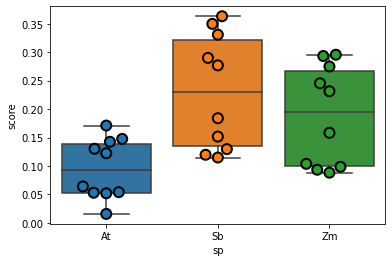

In [ ]:
sns.boxplot(data=conc, x="sp", y="score")
sns.swarmplot(data=conc, x="sp", y="score", size=10, edgecolor="black", linewidth=2)

In [ ]:
sns.boxplot(y=data["gkSVM_score"], x=data["MICROSCOPE_FXN"], order=microscope_order, palette=microscope_colors, ax=ax)
sns.swarmplot(y=data["gkSVM_score"], x=data["MICROSCOPE_FXN"], order=microscope_order, palette=microscope_colors, size=10, edgecolor="black", linewidth=2, ax=ax)
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16);
ax.set_xlabel("Microscope Classification", fontsize=20)
ax.set_ylabel("gkSVM Score", fontsize=20);

In [ ]:
r2_score(sdata_leaf.seqs_annot["enrichment"], sdata_leaf.seqs_annot["Jores21CNN_trial_1_enrichment_predictions"])


-27.533230872264056